In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import warnings
import re
from pathlib import Path

warnings.filterwarnings("ignore")

# Reward Distribution

In [108]:
def load_sequences(folder_path: Path):
    """
    Parses generated_sequences_for_algo_*.txt files in folder_path to extract
    sequence, reward, model info into a DataFrame.
    """
    pattern = re.compile(r"Sequence\s*(\d+):\s*([AUCG]+),\s*Reward:\s*([\d\.]+)")
    records = []
    for txt in folder_path.glob("generated_sequences_for_algo_*.txt"):
        model = txt.stem.split("_")[-1]
        with open(txt) as f:
            for line in f:
                m = pattern.search(line)
                if m:
                    seq_id = int(m.group(1))
                    seq, reward = m.group(2), float(m.group(3))
                    records.append({"model": model, "seq_id": seq_id, "sequence": seq, "reward": reward})
    return pd.DataFrame(records)

In [ ]:
def parse_table(file_path: Path, model_name: str):
    """
    Parses a markdown-style comparison table file into a DataFrame,
    adding a 'model' column with model_name.
    """
    with open(file_path, "r") as f:
        lines = f.readlines()

    data_lines = [line for line in lines if re.match(r"\|\s*\w+", line)]
    if not data_lines:
        return pd.DataFrame()  # empty if no table found
    
    header_line = data_lines[0]
    columns = [col.strip() for col in header_line.strip("| \n").split("|")]
    
    data = []
    for line in data_lines[1:]:
        row = [cell.strip() for cell in line.strip("| \n").split("|")]
        if len(row) == len(columns):
            row.append(model_name)  # add model name column
            data.append(row)
    
    columns.append("model")
    df = pd.DataFrame(data, columns=columns)
    
    numeric_cols = ["GC %", "MFE", "CAI", "Levenshtein", "Identity %"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

In [146]:
def plot_top20_avg_reward(df_seq, title="Top 20 mRNA Sequences Average Reward"):
    top20_df = (
        df_seq.sort_values(by=["model", "reward"], ascending=[True, False])
              .groupby("model", group_keys=False)
              .head(20)
    )
    avg_rewards = top20_df.groupby("model")["reward"].mean()
    avg_rewards.index = avg_rewards.index.str.upper()

    model_colors = {
        "LGGFN": "#1f77b4",  # blue
        "SAGFN": "#ff7f0e",  # orange
        "TB": "#2ca02c",     # green
    }
    colors = [model_colors.get(m, "#333333") for m in avg_rewards.index]

    plt.figure(figsize=(7, 5))
    bars = avg_rewards.plot(kind="bar", color=colors, edgecolor='black')
    plt.title(title, fontsize=12)
    plt.ylabel("Average Reward", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.ylim(avg_rewards.min() - 0.5, avg_rewards.max() + 0.5)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [144]:
def plot_avg_reward_evolution(df_seq, max_k=50, highlight_k=None, title="Evolution of Average Reward for Top-k Sequences"):
    if highlight_k is None:
        highlight_k = [10, 20, 30, 40, 50]
    sorted_df = df_seq.sort_values(by=["model", "reward"], ascending=[True, False])
    models = sorted_df["model"].unique()
    top_k_range = range(1, max_k + 1)
    avg_rewards_by_k = pd.DataFrame(index=top_k_range, columns=models)

    for k in top_k_range:
        top_k = (
            sorted_df.groupby("model", group_keys=False)
                     .head(k)
                     .groupby("model")["reward"]
                     .mean()
        )
        avg_rewards_by_k.loc[k] = top_k

    avg_rewards_by_k = avg_rewards_by_k.astype(float)

    plt.figure(figsize=(7, 5))
    for model in avg_rewards_by_k.columns:
        plt.plot(avg_rewards_by_k.index, avg_rewards_by_k[model], label=model.upper(), linewidth=1.8)
        plt.scatter(highlight_k, avg_rewards_by_k.loc[highlight_k, model], s=40, marker='o')

    plt.title(title, fontsize=12)
    plt.xticks(ticks=highlight_k, fontsize=12)
    plt.yticks(fontsize=10)
    plt.xlabel("Top-k", fontsize=12)
    plt.ylabel("Average Reward", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


Combined table head:
     Seq   GC %    MFE   CAI  Levenshtein  Identity %  model
0  Gen 1  53.78 -85.80  0.54           48       78.67  sagfn
1  Gen 2  52.89 -85.37  0.53           59       73.78  sagfn
2  Gen 3  55.56 -82.50  0.54           54       76.00  sagfn
3  Gen 4  54.67 -81.37  0.48           51       77.33  sagfn
4  Gen 5  52.89 -82.00  0.51           51       77.33  sagfn


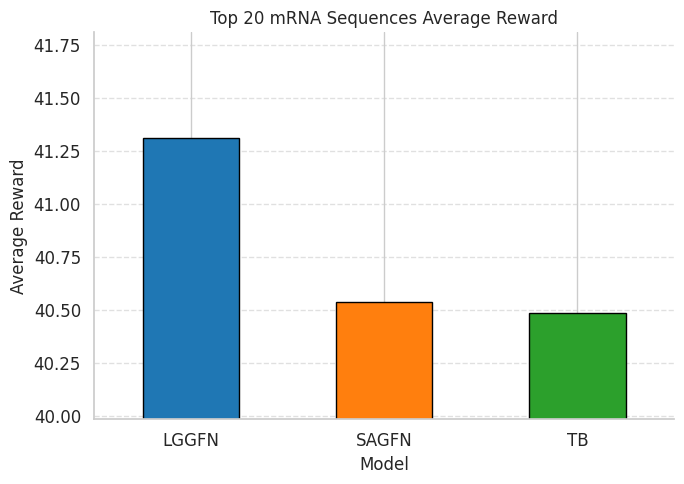

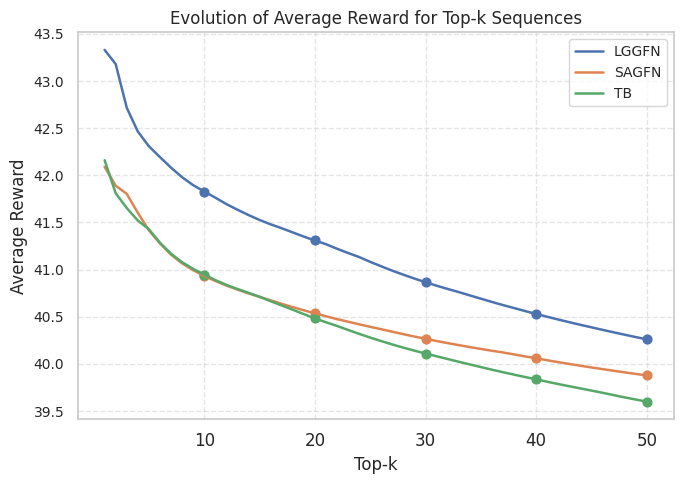

In [147]:
def main(base_folder):

    base_folder = Path(base_folder)

    df_seq = load_sequences(base_folder)

    files = {f.stem.split("_")[0]: f for f in base_folder.glob("*_comparison_table.txt")}
    dfs = [parse_table(path, model) for model, path in files.items()]
    combined_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    print("Combined table head:")
    print(combined_df.head())

    plot_top20_avg_reward(df_seq)

    plot_avg_reward_evolution(df_seq)

main("/home/ubuntu/aya/Loss-Guided-GFN/src/envs/Bio_env/small_prot")